# Imports

In [53]:
from tensorflow.keras.applications import VGG16

from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop, SGD, Adam

from tensorflow.keras import backend as BK

import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from  keras.metrics import Precision, Recall, Accuracy, BinaryAccuracy

from tensorflow.keras.callbacks import Callback, ModelCheckpoint

import matplotlib.pyplot as plt
# import seaborn as sns

from os import listdir

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

import numpy as np
import glob

import pandas as pd # for data manipulation

from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import classification_report # for model evaluation metrics
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

from tensorflow.keras.utils import to_categorical

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold, train_test_split
import numpy as np

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc

# Preparando dados

In [2]:

IMG_WIDTH=969
IMG_HEIGHT=370

IMG_DIM = (IMG_WIDTH, IMG_HEIGHT)

def map_caractere_barra(path):
    return path.replace("\\", "/")

# Recupera imagens para treino
train_files = glob.glob("D:/mestrado/notebooks/dados/espectrogramas_a_neutro_doente_saudavel/feminino/*")
train_files = list(map(map_caractere_barra, train_files))
print(train_files)

print(">> Quantidade total de dados: ", len(train_files))


train_imgs = [img_to_array(load_img(img, target_size=None)) for img in train_files]
train_imgs = np.array(train_imgs)

# recupera nome dos arquivos para mapear
train_labels = [fn.split('/')[-1].split('.')[0] for fn in train_files]
print(train_labels)

##### Criar dataframe para armazenar nomes
train_df = pd.DataFrame(train_labels)
# Renomeando o nome da coluna para arquivo
train_df = train_df.rename(columns={0:'file'})  


# Criando uma lista vazia onde terá todos labels para cada linha do dataframe
train_labels = []
categorical_labels = []
for i in range(0, len(train_df)):
    name = train_df['file'][i].split('-')[1].split('_')[0]
    if name == 'saudavel':
      label = 'saudavel'
      category = 0
    else:
      label = 'doente'
      category = 1
    train_labels.append(label)
    categorical_labels.append(category)

# Adiciona coluna ao dataframe
train_df['label'] = train_labels
train_df['category'] = categorical_labels
train_df

['D:/mestrado/notebooks/dados/espectrogramas_a_neutro_doente_saudavel/feminino/368-disfonia_f_a_neutro.png', 'D:/mestrado/notebooks/dados/espectrogramas_a_neutro_doente_saudavel/feminino/445-disfonia_f_a_neutro.png', 'D:/mestrado/notebooks/dados/espectrogramas_a_neutro_doente_saudavel/feminino/449-disfonia_f_a_neutro.png', 'D:/mestrado/notebooks/dados/espectrogramas_a_neutro_doente_saudavel/feminino/451-disfonia_f_a_neutro.png', 'D:/mestrado/notebooks/dados/espectrogramas_a_neutro_doente_saudavel/feminino/494-disfonia_f_a_neutro.png', 'D:/mestrado/notebooks/dados/espectrogramas_a_neutro_doente_saudavel/feminino/561-disfonia_f_a_neutro.png', 'D:/mestrado/notebooks/dados/espectrogramas_a_neutro_doente_saudavel/feminino/674-disfonia_f_a_neutro.png', 'D:/mestrado/notebooks/dados/espectrogramas_a_neutro_doente_saudavel/feminino/1057-disfonia_f_a_neutro.png', 'D:/mestrado/notebooks/dados/espectrogramas_a_neutro_doente_saudavel/feminino/1187-disfonia_f_a_neutro.png', 'D:/mestrado/notebooks/da

,file,label,category
0,368-disfonia_f_a_neutro,doente,1
1,445-disfonia_f_a_neutro,doente,1
2,449-disfonia_f_a_neutro,doente,1
3,451-disfonia_f_a_neutro,doente,1
4,494-disfonia_f_a_neutro,doente,1
...,...,...,...
415,1179-saudavel_f_a_neutro,saudavel,0
416,1180-saudavel_f_a_neutro,saudavel,0
417,1182-saudavel_f_a_neutro,saudavel,0
418,1184-saudavel_f_a_neutro,saudavel,0


In [3]:
X = train_imgs
print("Shape X: ")
print(X.shape)

# Normalizar as imagens para o intervalo [0, 1]
X = X.astype('float32') / 255.0
print("X")
print(X)

Y = np.array(train_df['category'])
print('Y')
print(Y)
lb = LabelEncoder()
ft = lb.fit_transform(Y)
# Codificando para usar na rede
# Hot encoding y
Y = to_categorical(Y, 2)
print(Y)

print("Shape Y: ")
print(Y.shape)

Shape X: 
(420, 370, 969, 3)
X
[[[[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  [[0.         0.         0.        ]
   [0.23921569 0.1882353  0.44705883]
   [0.25490198 0.2        0.4745098 ]
   ...
   [0.1764706  0.3882353  0.5254902 ]
   [0.1764706  0.3882353  0.5254902 ]
   [0.1764706  0.3882353  0.5254902 ]]

  [[0.         0.         0.        ]
   [0.25490198 0.2        0.4745098 ]
   [0.27058825 0.21568628 0.5058824 ]
   ...
   [0.1882353  0.4117647  0.5568628 ]
   [0.1882353  0.4117647  0.5568628 ]
   [0.1882353  0.4117647  0.5568628 ]]

  ...

  [[0.         0.         0.        ]
   [0.3372549  0.7411765  0.3647059 ]
   [0.36078432 0.78431374 0.3882353 ]
   ...
   [0.12941177 0.5647059  0.5529412 ]
   [0.12941177 0.5647059  0.5529412 ]
   [0.12941177 0.5647059  0.5529412 ]]

  [[0.        

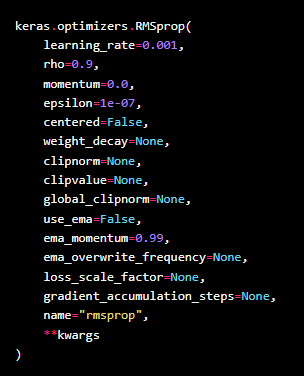

Função de ativação:  
— binary classification: layers.Dense(1, activation=’sigmoid’)  
— multi-class classification: layers.Dense(#classes, activation=’softmax’)   
— regression: layers.Dense(1, activation=None)  
  
Loss function:  
— binary classification: loss=’binary_crossentropy’  
— multi-class classification: loss=’categorical_crossentropy’  
— regression: loss=’mean_squared_error’  

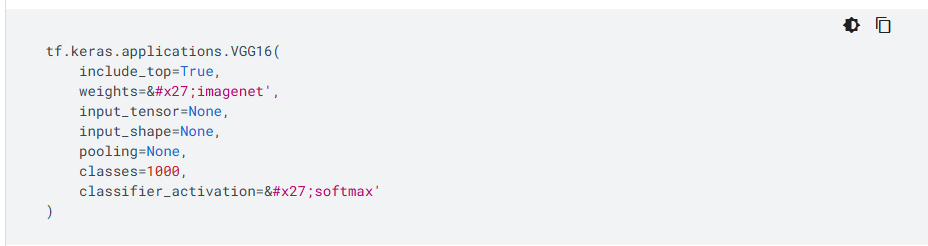
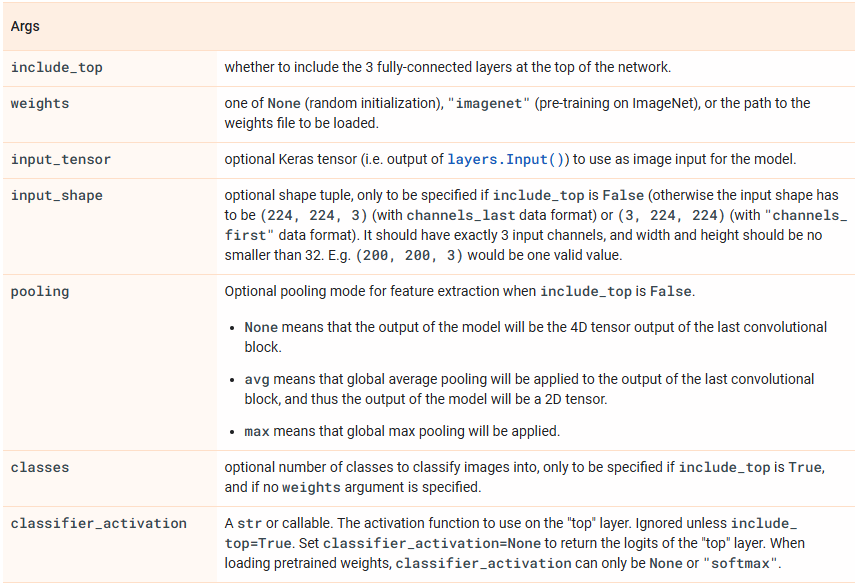

In [4]:
# Definir o F1-Score como uma métrica personalizada


def f1_score_metric(y_true, y_pred):
    # Convert probabilities to class predictions
    y_pred = BK.round(y_pred)
    
    # Calculate True Positives, False Positives, and False Negatives
    tp = BK.sum(y_true * y_pred)  # True positives
    fp = BK.sum((1 - y_true) * y_pred)  # False positives
    fn = BK.sum(y_true * (1 - y_pred))  # False negatives

    # Calculate precision and recall
    precision = tp / (tp + fp + BK.epsilon())  # Use epsilon to prevent division by zero
    recall = tp / (tp + fn + BK.epsilon())      # Use epsilon to prevent division by zero

    # Calculate F1 Score
    f1 = 2 * (precision * recall) / (precision + recall + BK.epsilon())  # Use epsilon here as well
    
    return f1

 


def vgg16_instance_compiled():

    # include_top = false faz com que a camada de saida seja removida
    base_model = VGG16(include_top=False, weights='imagenet', input_shape=(IMG_HEIGHT, IMG_WIDTH,3), pooling='avg', name='VGG16', classifier_activation=None, classes=2)

    # Congela aprendizado
    for layer in base_model.layers:
            layer.trainable = False

    print(base_model.output)

    #x = base_model.output
    print("veja:")
    print(base_model.layers[-2])
    x= base_model.layers[-2].output
    print(x)

    # Camada parra simplificar os dados (resume as features/valores)
    x = layers.GlobalAveragePooling2D()(x)

    # Caso a acurácia der muito baixa pode-se adicionar mais camadas fully-conected, entretanto existe risco de overfit.
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    # Camada de saída
    # x_inceptionV3 = layers.Dense(1, activation='sigmoid')(x_inceptionV3)
    output = layers.Dense(2, activation='softmax')(x)

    # Compilando o modelo
    model_VGG16 = Model(inputs=base_model.input, outputs=output)
    model_VGG16.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=[BinaryAccuracy(), Precision(), Recall(), f1_score_metric], run_eagerly=False)

    # model_VGG16.summary()
    
    return model_VGG16

## Montando condições de parada

In [5]:
# Classe que possui uma função para verificar as condições de parada a cada época de treino da rede
class mycallback(Callback):
    def on_epoch_end(self, epoch, logs={}):

        if epoch > 500:
             print("Número máximo de épocas excedido!")
             self.model.stop_training = True
        # Perda foi menor que o threshold
        if logs.get('loss') <= 0.09:
            self.model.stop_training = True

        # atingiu acurácia de 100%. (POSSIVEL OVERFIT)
        if logs.get('acc') == 1.00:
            self.model.stop_training = True


# Configuração do ModelCheckpoint
checkpoint_callback = ModelCheckpoint(
    filepath='/checkpoints/vgg16/feminino_doente_saudavel_ajuste_melhor_modelo.keras',      # Caminho onde o modelo será salvo
    monitor='val_loss',               # Métrica monitorada (ex: val_loss ou val_accuracy)
    save_best_only=True,              # Salva apenas o melhor modelo
    save_weights_only=False,          # Salva o modelo completo, incluindo arquitetura
    mode='min',                       # Modo de monitoramento (min para loss, max para accuracy)
    verbose=1                         # Exibe mensagens quando o modelo é salvo
)

callbacks = [mycallback(), checkpoint_callback]

In [8]:
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

# K-Fold Cross Validation

In [38]:
# Configurações da validação cruzada
kfold = KFold(n_splits=10, shuffle=True, random_state=32)
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

historicos = []  # Para salvar os históricos de treinamento
actual_classes = []  # Classes reais acumuladas
predicted_classes = []  # Classes previstas acumuladas


X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

print('tamanho da parte de treino ', len(X_train_val))
print('tamanho da parte de teste ', len(X_test))


# Iterar pelos folds
for fold, (train_index, val_index) in enumerate(kfold.split(X_train_val, Y_train_val)):
    print(f"\n\nCross-Validation Fold {fold + 1}\n")

    # Criar uma nova instância do modelo para cada fold
    model = vgg16_instance_compiled()

    # Dividir os dados
    x_train, x_val = X_train_val[train_index], X_train_val[val_index]
    y_train, y_val = Y_train_val[train_index], Y_train_val[val_index]

    # Early Stopping para evitar overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    
    #
    # callbacks=[early_stopping],
    # Treinar o modelo
    history = model.fit(
        x_train, y_train,
        epochs=20,
        validation_data=(x_val, y_val),
        verbose=1
    )

    # Salvar o histórico do treinamento
    historicos.append(history)

    teste =  model.predict(x_val)
    print('Valores previstos: ')
    print(teste)

    # Prever nos dados de teste
    y_pred = (teste > 0.5).astype(int)  # Binarizar as predições

    # Calcular métricas do fold
    # Necessário voltar do formato one-hot-encoded para rótulos simples
    y_val_converted = np.argmax(y_val, axis=1)
    y_pred_converted = np.argmax(y_pred, axis=1)

    accuracy = accuracy_score(y_val_converted, y_pred_converted)
    precision = precision_score(y_val_converted, y_pred_converted)
    recall = recall_score(y_val_converted, y_pred_converted)
    f1 = f1_score(y_val_converted, y_pred_converted)

    # Salvar métricas
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

    # Acumular classes reais e previstas
    actual_classes.extend(Y_test)
    predicted_classes.extend(y_pred)

    print(f"Fold {fold + 1} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

# Consolidar os resultados
print("\n\nFinal Cross-Validation Results:")
print(f"Mean Accuracy: {np.mean(accuracy_scores):.4f}")
print(f"Mean Precision: {np.mean(precision_scores):.4f}")
print(f"Mean Recall: {np.mean(recall_scores):.4f}")
print(f"Mean F1-Score: {np.mean(f1_scores):.4f}")

tamanho da parte de treino  336
tamanho da parte de teste  84


Cross-Validation Fold 1

<KerasTensor shape=(None, 512), dtype=float32, sparse=False, name=keras_tensor_379>
veja:
<MaxPooling2D name=block5_pool, built=True>
<KerasTensor shape=(None, 11, 30, 512), dtype=float32, sparse=False, name=keras_tensor_378>
Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 150s 14s/step - binary_accuracy: 0.5439 - f1_score_metric: 0.5431 - loss: 0.7603 - precision_12: 0.5439 - recall_12: 0.5439 - val_binary_accuracy: 0.3824 - val_f1_score_metric: 0.2031 - val_loss: 0.7375 - val_precision_12: 0.3824 - val_recall_12: 0.3824
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 141s 14s/step - binary_accuracy: 0.4824 - f1_score_metric: 0.4816 - loss: 0.7821 - precision_12: 0.4824 - recall_12: 0.4824 - val_binary_accuracy: 0.6176 - val_f1_score_metric: 0.7969 - val_loss: 0.6778 - val_precision_12: 0.6176 - val_recall_12: 0.6176
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 141s 14s/step - binary_accuracy: 0.4523 - f1_score_metric: 0.45

In [39]:
print(f"Treino: {x_train.shape}, Validação: {x_val.shape}, Teste: {X_test.shape}")

Treino: (303, 370, 969, 3), Validação: (33, 370, 969, 3), Teste: (84, 370, 969, 3)


In [54]:
print(f"Treino: {X_train_val.shape}, Teste: {X_test.shape}")

# Re-treinar o modelo final usando todos os dados de treino+validação
model_final = vgg16_instance_compiled()
historico_final = model_final.fit(X_train_val, Y_train_val, epochs=20, verbose=2)

# Avaliar no conjunto de teste final
y_test_pred = (model_final.predict(X_test) > 0.6).astype(int)

# Converter rótulos de teste para formato unidimensional
Y_test_uni = np.argmax(Y_test, axis=1)
y_test_pred_uni = np.argmax(y_test_pred, axis=1)


Treino: (336, 370, 969, 3), Teste: (84, 370, 969, 3)
<KerasTensor shape=(None, 512), dtype=float32, sparse=False, name=keras_tensor_709>
veja:
<MaxPooling2D name=block5_pool, built=True>
<KerasTensor shape=(None, 11, 30, 512), dtype=float32, sparse=False, name=keras_tensor_708>
Epoch 1/20
11/11 - 160s - 15s/step - binary_accuracy: 0.4554 - f1_score_metric: 0.4489 - loss: 0.7959 - precision_23: 0.4554 - recall_23: 0.4554
Epoch 2/20
11/11 - 152s - 14s/step - binary_accuracy: 0.4673 - f1_score_metric: 0.4716 - loss: 0.7494 - precision_23: 0.4673 - recall_23: 0.4673
Epoch 3/20
11/11 - 314s - 29s/step - binary_accuracy: 0.4792 - f1_score_metric: 0.4858 - loss: 0.7192 - precision_23: 0.4792 - recall_23: 0.4792
Epoch 4/20
11/11 - 916s - 83s/step - binary_accuracy: 0.4792 - f1_score_metric: 0.4886 - loss: 0.7181 - precision_23: 0.4792 - recall_23: 0.4792
Epoch 5/20
11/11 - 740s - 67s/step - binary_accuracy: 0.4970 - f1_score_metric: 0.4972 - loss: 0.7084 - precision_23: 0.4970 - recall_23: 0.4

In [55]:
# Calcular métricas no teste final
accuracy_test = accuracy_score(Y_test_uni, y_test_pred_uni)
precision_test = precision_score(Y_test_uni, y_test_pred_uni, average='binary')
recall_test = recall_score(Y_test_uni, y_test_pred_uni, average='binary')
f1_test = f1_score(Y_test_uni, y_test_pred_uni, average='binary')

print("\n\nFinal Test Results:")
print(f"Accuracy: {accuracy_test:.4f}")
print(f"Precision: {precision_test:.4f}")
print(f"Recall: {recall_test:.4f}")
print(f"F1-Score: {f1_test:.4f}")

# Salvar o modelo final
model_final.save('/checkpoints/vgg16/vgg16_final_feminino_model.keras')



Final Test Results:
Accuracy: 0.7024
Precision: 0.8400
Recall: 0.5000
F1-Score: 0.6269


In [56]:
len(np.argmax(Y_test, axis=1))

84

In [57]:
len(np.argmax(y_test_pred, axis=1))

84

In [58]:
630/60

10.5

In [62]:
import pandas as pd

path_to_save = "/vgg16/vgg16_feminino_doente_saudavel"

df_concatenado = pd.DataFrame()
for i in range(0, len(historicos)):
    df_aux = pd.DataFrame(historicos[i].history)
    if( i > 0):
        df_aux = df_aux.rename(columns={"precision_{}".format(i) : "precision", "val_precision_{}".format(i) : "val_precision", "recall_{}".format(i) : "recall", "val_recall_{}".format(i) : "val_recall"})

    df_aux["k_folder"] = i + 1
    df_concatenado = pd.concat([df_concatenado, df_aux], ignore_index=True)

df_concatenado.to_csv("D:/mestrado/notebooks/historicos{}{}".format(path_to_save, ".csv"), index=False)


print("DataFrame salvo em arquivo.csv com sucesso!")

DataFrame salvo em arquivo.csv com sucesso!


In [61]:
# Carregar o CSV em um DataFrame
path_to_save = "/vgg16/vgg16_feminino_doente_saudavel"
df_loaded = pd.read_csv("D:/mestrado/notebooks/historicos{}.csv".format(path_to_save))

df_loaded.head()

df_loaded.describe()

,binary_accuracy,f1_score_metric,loss,precision,recall,val_binary_accuracy,val_f1_score_metric,val_loss,val_precision,val_recall,k_folder
count,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000
mean,0.681048,0.681295,0.592530,0.681048,0.681048,0.706619,0.711817,0.574365,0.706619,0.706619,3.000000
std,0.086670,0.086514,0.069689,0.086670,0.086670,0.080323,0.083587,0.067731,0.080323,0.080323,1.417051
min,0.449405,0.457386,0.485443,0.449405,0.449405,0.428571,0.406250,0.457656,0.428571,0.428571,1.000000
25%,0.639881,0.642756,0.544409,0.639881,0.639881,0.678571,0.682812,0.515414,0.678571,0.678571,2.000000
50%,0.718750,0.721591,0.565812,0.718750,0.718750,0.732143,0.738542,0.575417,0.732143,0.732143,3.000000
75%,0.741071,0.740767,0.638376,0.741071,0.741071,0.761905,0.768750,0.609615,0.761905,0.761905,4.000000
max,0.779762,0.789773,0.783498,0.779762,0.779762,0.809524,0.804167,0.699957,0.809524,0.809524,5.000000


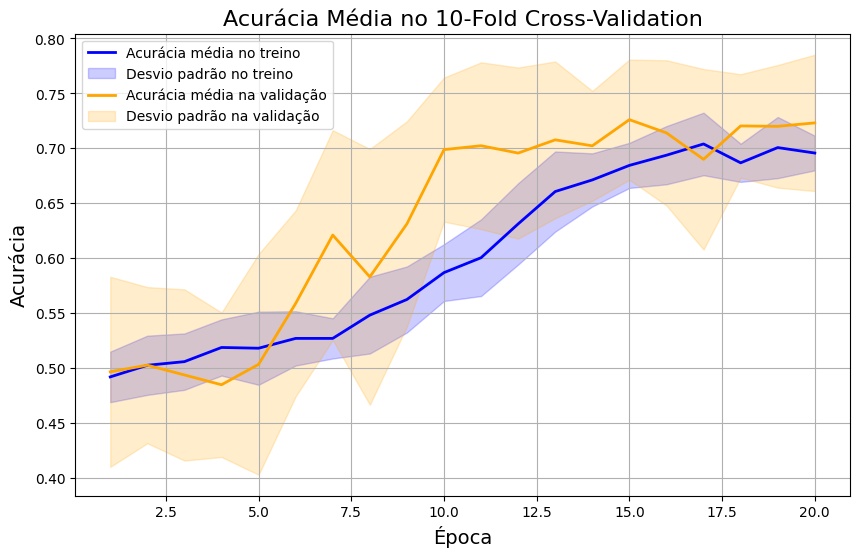

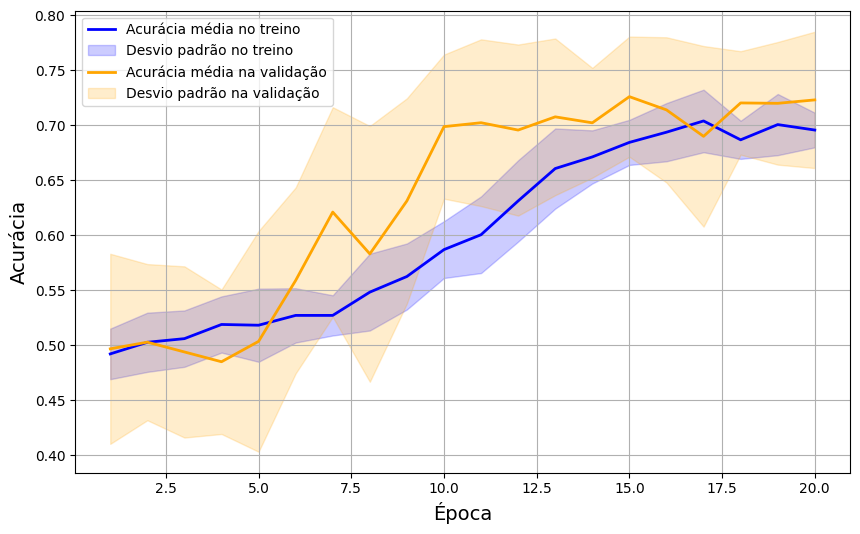

In [100]:
def plot_kfold_accuracy(histories, title=True):
    """
    Plota a curva de acurácia média para treino e validação durante o k-fold cross-validation.

    :param histories: Lista de objetos 'history' retornados por model.fit para cada fold.
    """
    # Inicializar listas para armazenar as métricas de treino e validação
    training_accuracies = []
    validation_accuracies = []

    # Iterar pelos históricos de cada fold
    for history in histories:
        training_accuracies.append(history.history['binary_accuracy'])
        if 'val_binary_accuracy' in history.history:
            validation_accuracies.append(history.history['val_binary_accuracy'])

    # Calcular as médias e desvios padrão por época
    training_accuracies = np.array(training_accuracies)
    validation_accuracies = np.array(validation_accuracies)

    mean_train = np.mean(training_accuracies, axis=0)
    std_train = np.std(training_accuracies, axis=0)
    
    mean_val = np.mean(validation_accuracies, axis=0)
    std_val = np.std(validation_accuracies, axis=0)

    # Plotar as curvas de acurácia
    epochs = range(1, len(mean_train) + 1)
    plt.figure(figsize=(10, 6))
    
    # Acurácia de treino
    plt.plot(epochs, mean_train, label='Acurácia média no treino', color='blue', linewidth=2)
    plt.fill_between(epochs, mean_train - std_train, mean_train + std_train, color='blue', alpha=0.2, label='Desvio padrão no treino')
    
    # Acurácia de validação
    plt.plot(epochs, mean_val, label='Acurácia média na validação', color='orange', linewidth=2)
    plt.fill_between(epochs, mean_val - std_val, mean_val + std_val, color='orange', alpha=0.2, label='Desvio padrão na validação')
    
    # Configurações do gráfico
    if title:
        plt.title('Acurácia Média no 10-Fold Cross-Validation', fontsize=16)
    plt.xlabel('Época', fontsize=14)
    plt.ylabel('Acurácia', fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(True)
    plt.show()

plot_kfold_accuracy(historicos)
plot_kfold_accuracy(historicos, False)


In [68]:
def plot_training_loss(history, title=True):
    # Verifica se 'loss' está disponível no histórico
    if 'loss' not in history.history:
        print("Loss data not found in history. Check if the metric was included during compilation.")
        return
    
    # Recupera os valores de perda
    losses = history.history['loss']
    
    # Plotar a perda do treino
    plt.figure(figsize=(10, 6))
    plt.plot(losses, label='Perda no treinamento', marker='o', color='indianred')
    
    # Adicionar os valores de perda no gráfico
    for i, loss in enumerate(losses):
        plt.annotate(f"{loss:.2f}", (i, loss), textcoords="offset points", xytext=(0, 7), ha='center', fontsize=10)
    
    # Configurações do gráfico
    if title:
        plt.title('Perda no Treinamento', fontsize=16)
    plt.xlabel('Épocas', fontsize=14)
    plt.ylabel('Perda', fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(alpha=0.5)
    plt.tight_layout()
    
    # Exibir o gráfico
    plt.show()

In [73]:
def plot_training_accuracy(history, title = True):
    if 'binary_accuracy' not in history.history:
        print("Accuracy data not found in history. Check if the metric was included during compilation.")
        return

    # Plotar a acurácia do treino
    plt.figure(figsize=(10, 6))
    accuracies = history.history['binary_accuracy']

    # Plotando a curva de acurácia
    plt.plot(accuracies, label='Acurácia no treinamento', marker='o', color='royalblue')

    # Adicionar valores de acurácia no gráfico
    for i, acc in enumerate(accuracies):
        plt.annotate(f"{acc:.2f}", (i, acc), textcoords="offset points", xytext=(0, 7), ha='center', fontsize=10)

    # Configurações do gráfico
    if title:
        plt.title('Acurácia no Treinamento', fontsize=16)
    plt.xlabel('Épocas', fontsize=14)
    plt.ylabel('Acurácia', fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(alpha=0.4)
    plt.tight_layout()

    # Exibir o gráfico
    plt.show()


In [97]:
import matplotlib.pyplot as plt

def plot_training_metrics(history, title = True):
    # Criar uma figura com duas subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1 linha, 2 colunas
    
    # Plotando a acurácia
    if 'binary_accuracy' in history.history:
        accuracies = history.history['binary_accuracy']
        axes[0].plot(accuracies, label='Acurácia no treinamento', marker='o', color='royalblue')
        for i, acc in enumerate(accuracies):
            axes[0].annotate(f"{acc:.2f}", (i, acc), textcoords="offset points", xytext=(0, 7), ha='center', fontsize=10)
        axes[0].set_title('Acurácia no Treinamento', fontsize=16)
        axes[0].set_xlabel('Épocas', fontsize=14)
        axes[0].set_ylabel('Acurácia', fontsize=14)
        axes[0].legend(fontsize=10)
        axes[0].grid(alpha=0.4)
    else:
        axes[0].text(0.5, 0.5, "Acurácia não disponível", ha='center', va='center', fontsize=14)

    # Plotando a perda
    if 'loss' in history.history:
        losses = history.history['loss']
        axes[1].plot(losses, label='Perda no treinamento', marker='o', color='indianred')
        for i, loss in enumerate(losses):
            axes[1].annotate(f"{loss:.2f}", (i, loss), textcoords="offset points", xytext=(0, 7), ha='center', fontsize=10)
        axes[1].set_title('Perda no Treinamento', fontsize=16)
        axes[1].set_xlabel('Épocas', fontsize=14)
        axes[1].set_ylabel('Perda', fontsize=14)
        axes[1].legend(fontsize=10)
        axes[1].grid(alpha=0.5)
    else:
        axes[1].text(0.5, 0.5, "Perda não disponível", ha='center', va='center', fontsize=14)

    # Ajustando o layout para melhor visualização
    plt.tight_layout()
    
    # Exibir os gráficos
    plt.show()

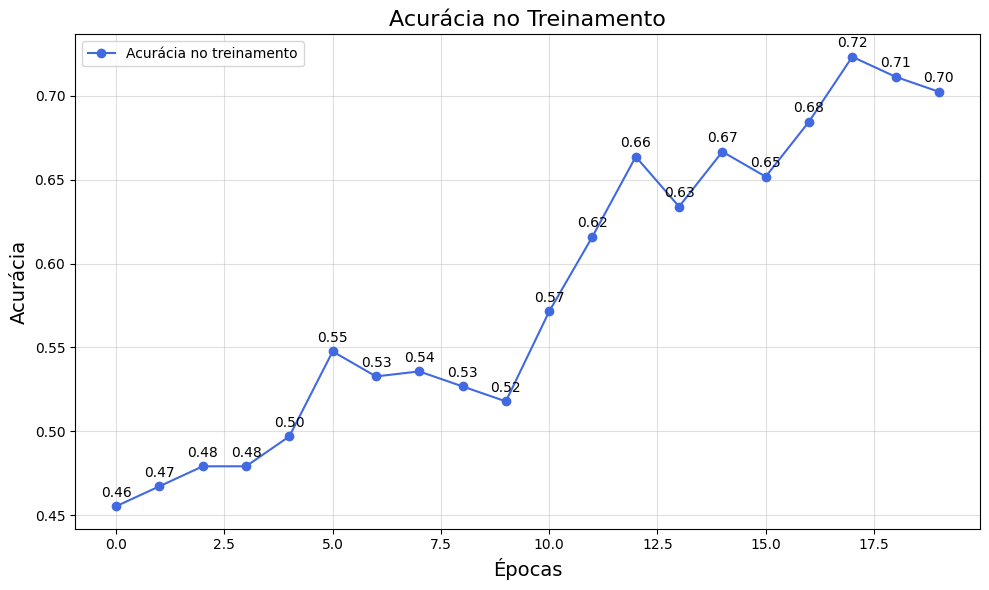

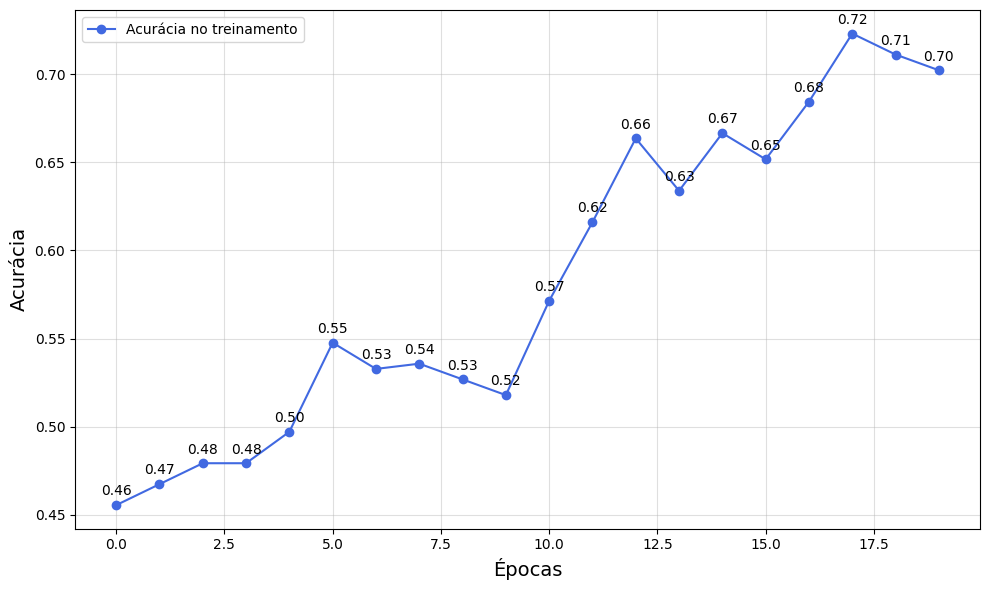

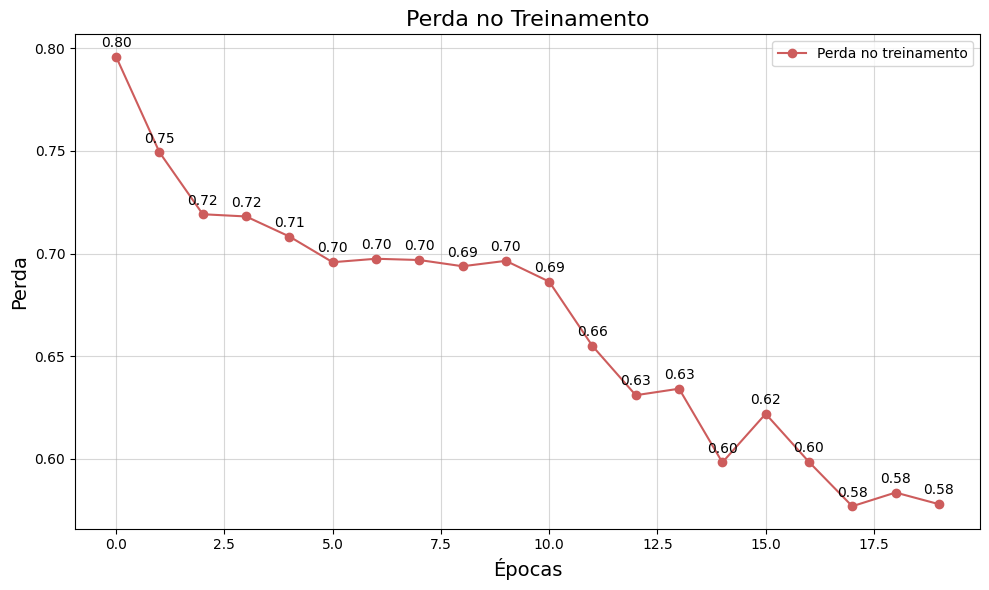

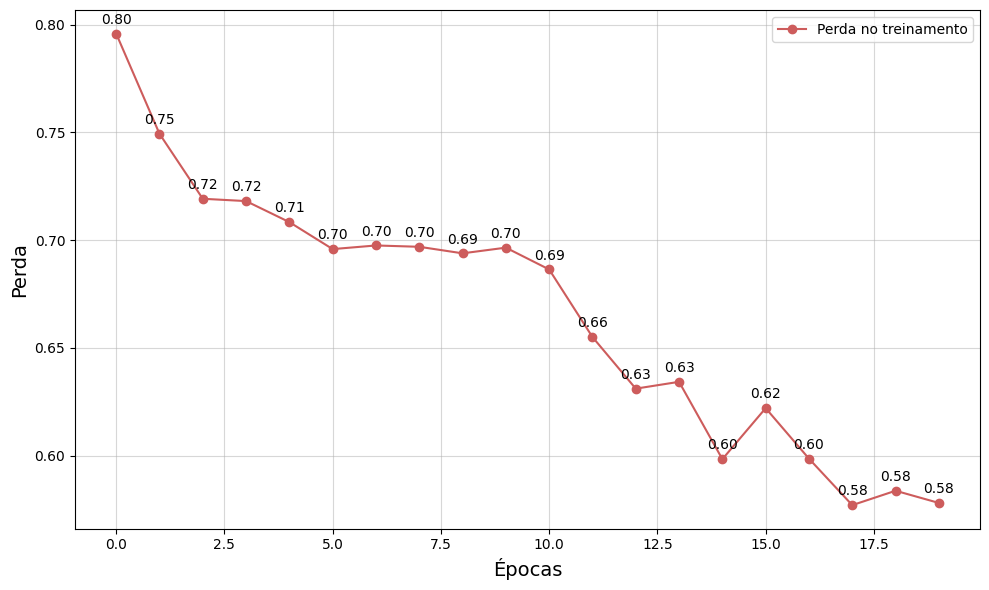

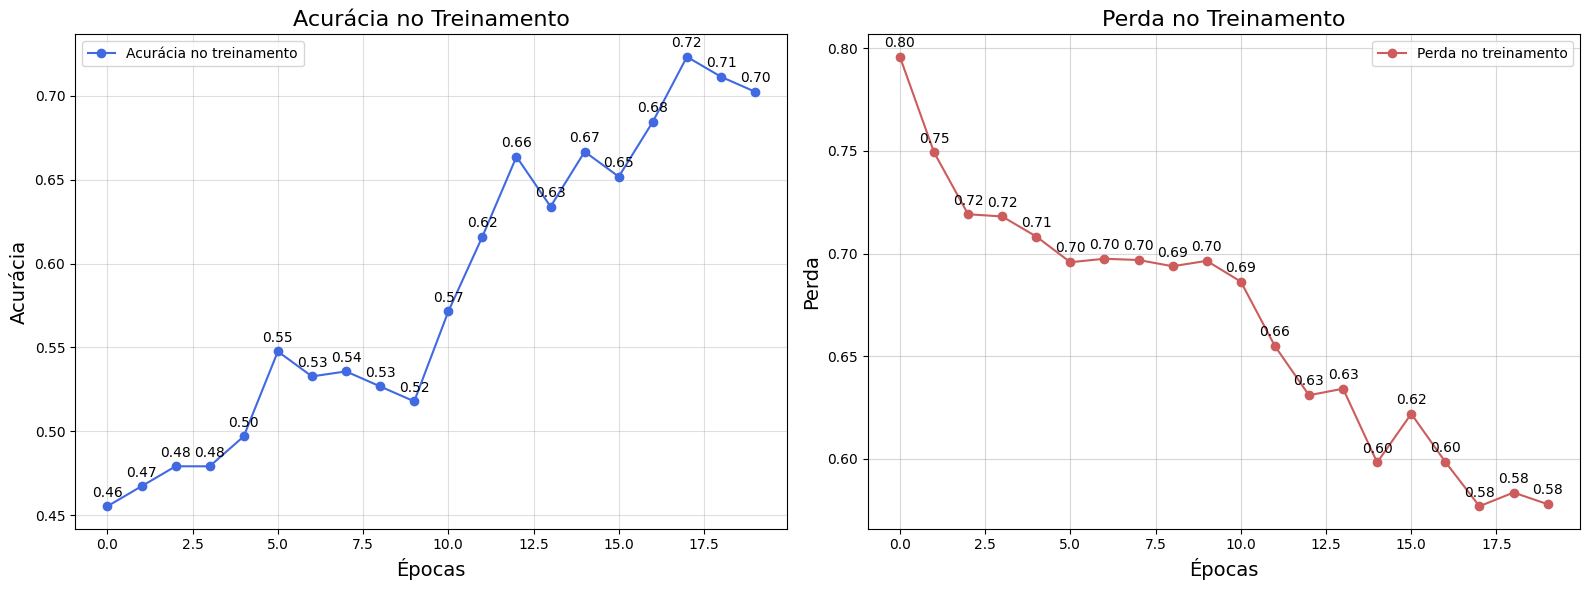

In [98]:
# Chamar a função com o histórico do treinamento final
plot_training_accuracy(historico_final)
plot_training_accuracy(historico_final, False)

# Chamar a função com o histórico do treinamento final
plot_training_loss(historico_final)
plot_training_loss(historico_final, False)

plot_training_metrics(historico_final)

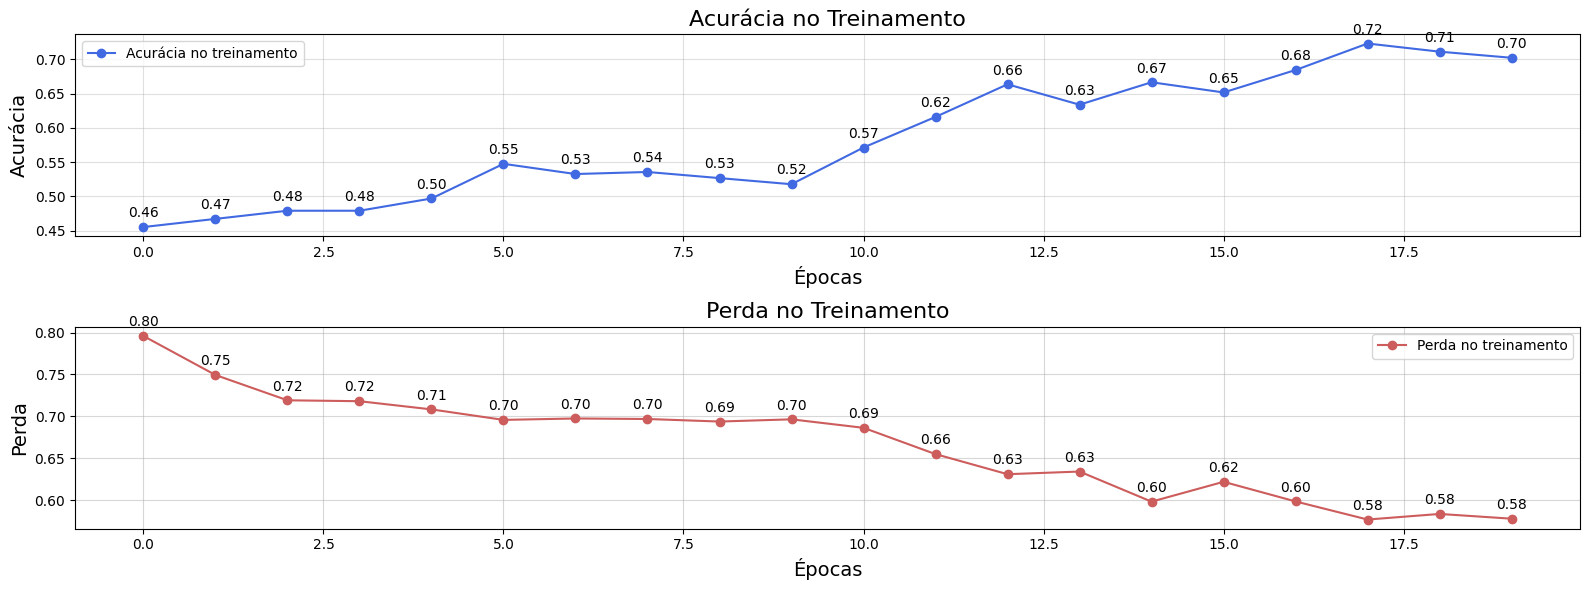

In [105]:
import matplotlib.pyplot as plt

def plot_training_metrics(history, title = True):
    # Criar uma figura com duas subplots
   # fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1 linha, 2 colunas
    fig, axes = plt.subplots(2, 1, figsize=(16, 6))
    
    # Plotando a acurácia
    if 'binary_accuracy' in history.history:
        accuracies = history.history['binary_accuracy']
        axes[0].plot(accuracies, label='Acurácia no treinamento', marker='o', color='royalblue')
        for i, acc in enumerate(accuracies):
            axes[0].annotate(f"{acc:.2f}", (i, acc), textcoords="offset points", xytext=(0, 7), ha='center', fontsize=10)
        axes[0].set_title('Acurácia no Treinamento', fontsize=16)
        axes[0].set_xlabel('Épocas', fontsize=14)
        axes[0].set_ylabel('Acurácia', fontsize=14)
        axes[0].legend(fontsize=10)
        axes[0].grid(alpha=0.4)
    else:
        axes[0].text(0.5, 0.5, "Acurácia não disponível", ha='center', va='center', fontsize=14)

    # Plotando a perda
    if 'loss' in history.history:
        losses = history.history['loss']
        axes[1].plot(losses, label='Perda no treinamento', marker='o', color='indianred')
        for i, loss in enumerate(losses):
            axes[1].annotate(f"{loss:.2f}", (i, loss), textcoords="offset points", xytext=(0, 7), ha='center', fontsize=10)
        axes[1].set_title('Perda no Treinamento', fontsize=16)
        axes[1].set_xlabel('Épocas', fontsize=14)
        axes[1].set_ylabel('Perda', fontsize=14)
        axes[1].legend(fontsize=10)
        axes[1].grid(alpha=0.5)
    else:
        axes[1].text(0.5, 0.5, "Perda não disponível", ha='center', va='center', fontsize=14)

    # Ajustando o layout para melhor visualização
    plt.tight_layout()
    
    # Exibir os gráficos
    plt.show()

plot_training_metrics(historico_final)

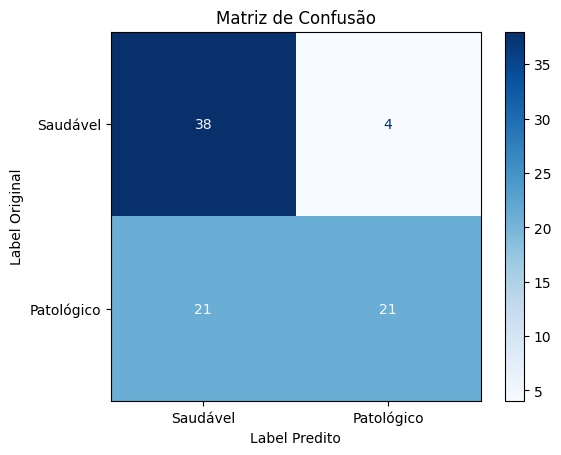

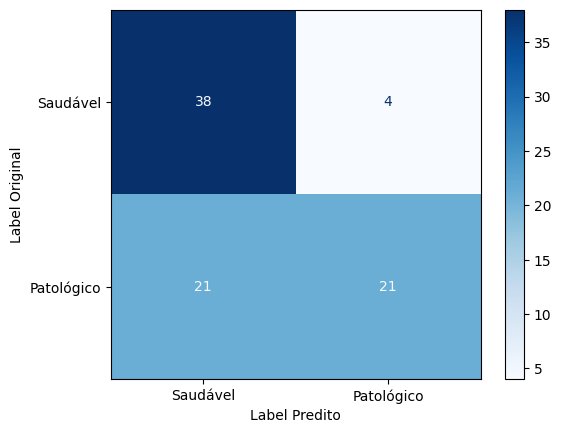

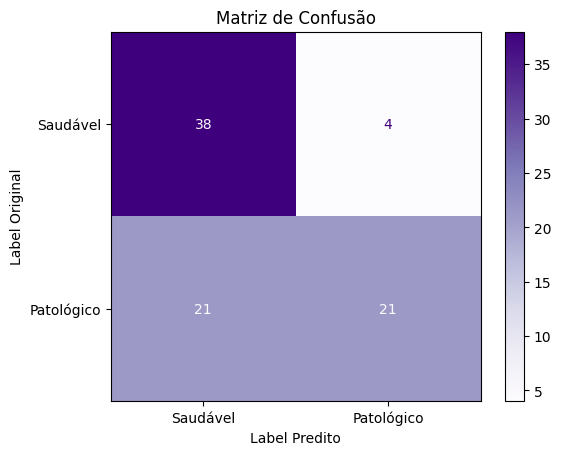

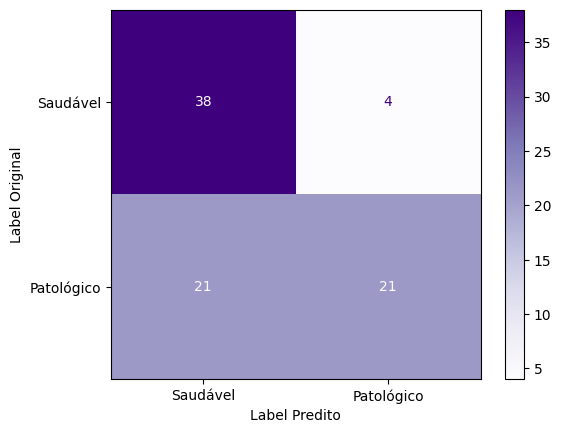

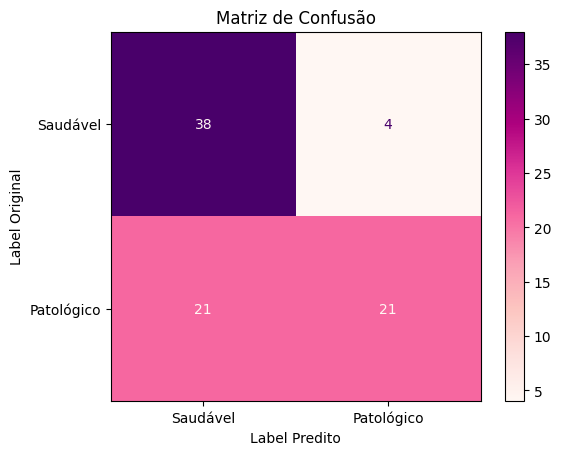

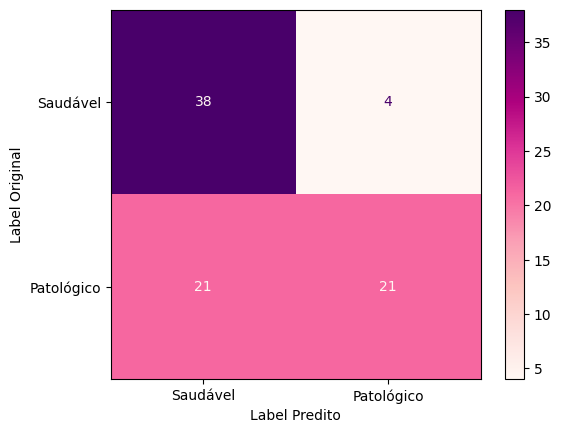

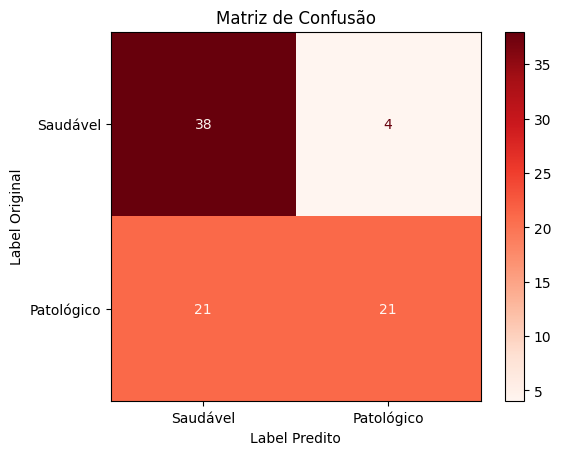

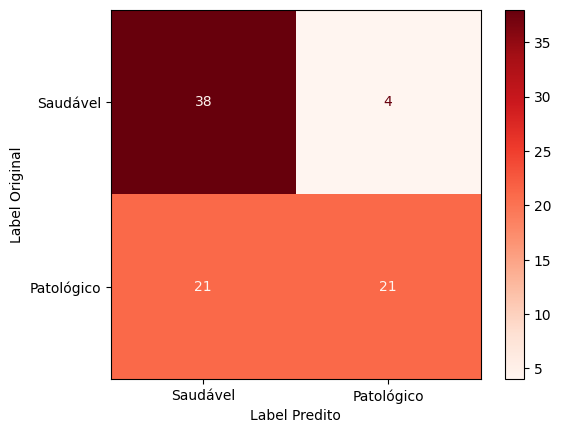

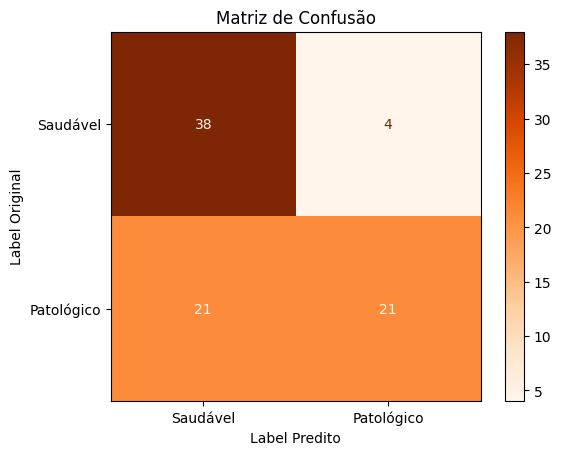

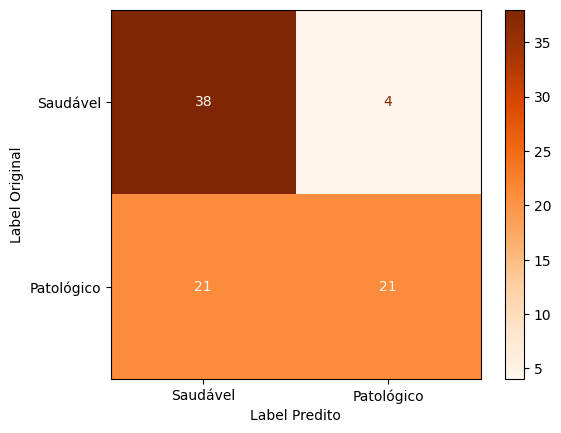

In [85]:


# y_pred_classes = (y_pred > 0.8).astype(int)  # Converter probabilidades para 0 ou 1

# Criar matriz de confusão
cm = confusion_matrix(Y_test_uni, y_test_pred_uni)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Saudável', 'Patológico'])

# Plotar matriz
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusão')
plt.xlabel('Label Predito')
plt.ylabel('Label Original')
plt.show()

disp.plot(cmap=plt.cm.Blues)
#plt.title('Matriz de Confusão')
plt.xlabel('Label Predito')
plt.ylabel('Label Original')
plt.show()

disp.plot(cmap=plt.cm.Purples)
plt.title('Matriz de Confusão')
plt.xlabel('Label Predito')
plt.ylabel('Label Original')
plt.show()

disp.plot(cmap=plt.cm.Purples)
#plt.title('Matriz de Confusão')
plt.xlabel('Label Predito')
plt.ylabel('Label Original')
plt.show()

disp.plot(cmap=plt.cm.RdPu)
plt.title('Matriz de Confusão')
plt.xlabel('Label Predito')
plt.ylabel('Label Original')
plt.show()

disp.plot(cmap=plt.cm.RdPu)
#plt.title('Matriz de Confusão')
plt.xlabel('Label Predito')
plt.ylabel('Label Original')
plt.show()

disp.plot(cmap=plt.cm.Reds)
plt.title('Matriz de Confusão')
plt.xlabel('Label Predito')
plt.ylabel('Label Original')
plt.show()

disp.plot(cmap=plt.cm.Reds)
#plt.title('Matriz de Confusão')
plt.xlabel('Label Predito')
plt.ylabel('Label Original')
plt.show()

disp.plot(cmap=plt.cm.Oranges)
plt.title('Matriz de Confusão')
plt.xlabel('Label Predito')
plt.ylabel('Label Original')
plt.show()

disp.plot(cmap=plt.cm.Oranges)
#plt.title('Matriz de Confusão')
plt.xlabel('Label Predito')
plt.ylabel('Label Original')
plt.show()



In [93]:
Y_test_uni

array([0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1], dtype=int64)

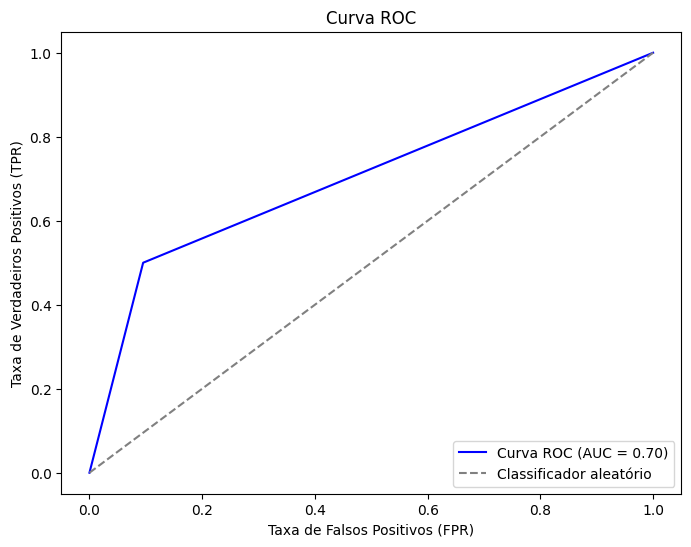

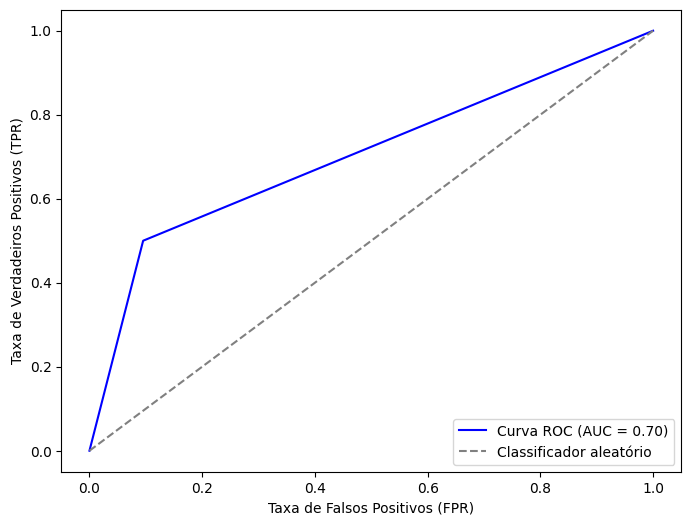

In [94]:
def plot_roc_curve(title = True):
    ### Receiver Operating Characteristic (ROC) Curve
    # Calcular curva ROC
    fpr, tpr, thresholds = roc_curve(Y_test_uni, y_test_pred_uni)
    roc_auc = auc(fpr, tpr)

    # Plotar a curva ROC
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'Curva ROC (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Classificador aleatório')
    if title:
        plt.title('Curva ROC')
    plt.xlabel('Taxa de Falsos Positivos (FPR)')
    plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
    plt.legend(loc='lower right')
    plt.show()

plot_roc_curve()
plot_roc_curve(False)

